# Lab 6. 基于Mindspore和LeNet5实现手写数字识别

## 实验目的
1. 使用MindSpore实现Lab5的三层神经网络
2. 了解卷积神经网络LeNet5的网络结构
3. 体验LeNet5在MindSpore平台下的构建

## 安装实验环境（Mindspore）

通过[(https://www.mindspore.cn/install)](https://www.mindspore.cn/install)构建安装指令。建议选择2.2.14版本的Mindspore, 在选定CPU、GPU、操作系统、Python版本等因素后，会生成安装指令，然后在本机运行

Mindspore的官方教程：[(https://www.mindspore.cn/tutorials/zh-CN/r2.3.1/index.html)](https://www.mindspore.cn/tutorials/zh-CN/r2.3.1/index.html)

MindSpore的官方API文档：[(https://www.mindspore.cn/docs/zh-CN/r2.3.1/index.html)](https://www.mindspore.cn/docs/zh-CN/r2.3.1/index.html)

可以参考[华为官方的教程](https://www.mindspore.cn/tutorials/zh-CN/r2.3.1/beginner/quick_start.html)

## 1. 准备数据

In [51]:
import mindspore
from mindspore import ops
from mindspore import nn
from mindspore.dataset import vision, transforms
from mindspore.dataset import MnistDataset

### 1.1 读取数据

In [52]:
# 加载MNIST数据集
train_dataset_original = MnistDataset('./MNIST/train')
test_dataset_original = MnistDataset('./MNIST/test')
print(train_dataset_original.get_col_names())

['image', 'label']


### 1.2 数据预处理

In [53]:
def create_dataset(dataset, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    return dataset

train_dataset = create_dataset(train_dataset_original, 64)
test_dataset = create_dataset(test_dataset_original, 64)

In [54]:
print(train_dataset.get_dataset_size())

for image, label in train_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

print(test_dataset.get_dataset_size())
for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break

938
Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32
157
Shape of image [N, C, H, W]: (64, 1, 28, 28) Float32
Shape of label: (64,) Int32


### 1.3 可视化部分手写数字图片

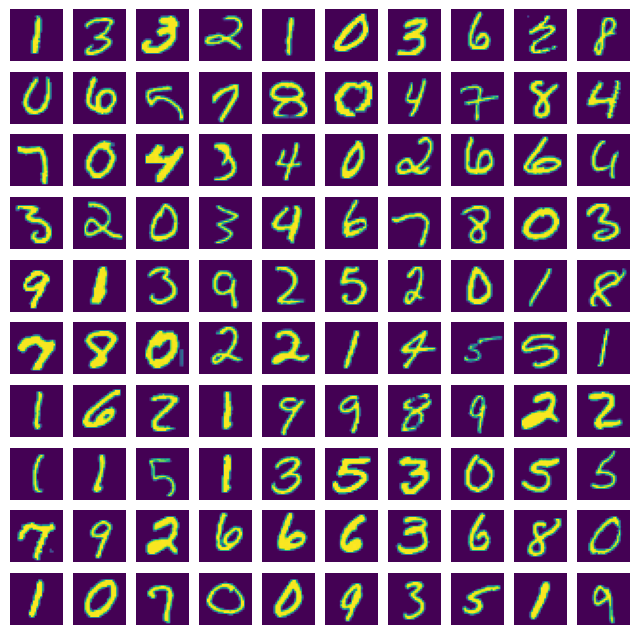

In [55]:
import matplotlib.pyplot as plt

mnist_dataset = MnistDataset('./MNist/train', num_samples=100)

# 设置图像大小 
plt.figure(figsize=(8,8)) 
i=1
# 打印100张子图
for dic in mnist_dataset.create_dict_iterator(output_numpy=True):
    plt.subplot(10,10,i) 
    plt.imshow(dic['image'][:,:,0]) 
    plt.axis('off')
    i += 1
plt.show()

## 2. 利用Mindspore实现传统神经网络手写数字识别

### 2.1 传统神经网络的构建

In [56]:
# 网络构建
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )
    
    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits
    
bpnn = Network()
print(bpnn)

Network<
  (flatten): Flatten<>
  (dense_relu_sequential): SequentialCell<
    (0): Dense<input_channels=784, output_channels=512, has_bias=True>
    (1): ReLU<>
    (2): Dense<input_channels=512, output_channels=512, has_bias=True>
    (3): ReLU<>
    (4): Dense<input_channels=512, output_channels=10, has_bias=True>
    >
  >


### 2.2 使用随机梯度下降SGD训练神经网络模型

In [57]:
from mindspore.train import Model

# 模型训练
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(bpnn.trainable_params(), 1e-2)

model = Model(bpnn, loss_fn=loss_fn, optimizer=optimizer, metrics={'acc', 'loss'})
model.train(epoch = 2, train_dataset = train_dataset)

### 2.3 网络模型的测试

Model.eval()返回的metric是Model.train()里通过参数定义的

In [58]:
metrics = model.eval(test_dataset, dataset_sink_mode=False)
print('Metrics:', metrics)

Metrics: {'loss': 0.24920423608866465, 'acc': 0.9268}


### 2.4 保存模型（检查点）

In [59]:
# Save checkpoint
mindspore.save_checkpoint(bpnn, "bpnn.ckpt")
print("Saved Model to bpnn.ckpt")

Saved Model to bpnn.ckpt


### 2.5 加载模型并进行预测

#### 2.5.1 加载模型

In [60]:
# Instantiate a random initialized model
bpnn = Network()
# Load checkpoint and load parameter to model
params = mindspore.load_checkpoint("bpnn.ckpt")
mindspore.load_param_into_net(bpnn, params)
model = Model(bpnn)

#### 2.5.2 用加载好的模型去预测
使用一个batch的数据进行预测

In [61]:
for img, label in test_dataset:
    rslt = model.predict(img)
    print(rslt.argmax(1))
    print(label)
    break

[8 7 3 1 1 1 2 0 8 3 6 9 5 5 8 1 7 6 2 6 9 6 8 8 9 9 2 1 0 8 6 7 2 8 5 6 8
 9 1 0 4 6 3 3 3 1 6 1 7 2 0 3 4 8 2 0 1 1 8 4 9 1 6 1]
[8 7 3 1 1 1 2 0 8 5 6 9 5 5 8 1 7 6 2 6 9 6 8 8 4 9 2 1 0 8 6 7 2 8 5 6 8
 9 1 0 4 6 3 7 3 1 6 1 7 2 0 3 4 8 2 0 1 1 8 4 9 1 6 1]


## 3. 使用MindSpore实现卷积神经网络LeNet5

![](assets/images/2024-04-07-22-36-11.png)


根据上图说明的参数，实现LeNet5网络，完成手写数字识别任务，部分代码已给出，你需要补全代码

你可能会用到的[MindSpore卷积神经网络API](https://www.mindspore.cn/docs/zh-CN/r2.1/api_python/mindspore.nn.html#%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%B1%82)

In [62]:
import os
import numpy as np
from mindspore import Model
import mindspore.dataset as ds

# !设置全局种子，这里改成你的学号后四位
np.random.seed(3652)
mindspore.set_seed(3652)

### 3.1 创建数据集

In [63]:
def create_dataset_v2(dataset, batch_size):
    image_transforms = [
        vision.Resize((32, 32)),
        vision.Rescale(rescale=1/(255*0.3081), shift=-0.1307/0.3081),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size)
    # dataset = dataset.shuffle(buffer_size=64).batch(batch_size, drop_remainder=True)
    return dataset

train_dataset_original = MnistDataset('./MNIST/train')

train_dataset = create_dataset_v2(train_dataset_original, 32)


### 3.2 创建LeNet5网络

In [64]:
# 根据LeNet5的网络结构创建模型
# 卷积的函数为nn.Conv2d(in_channel, out_channel, kernel_size, pad_mode='valid')
# 池化层nn.MaxPool2d(kernel_size, stride)
# 全连接层nn.Dense()
class LeNet5(nn.Cell):
    '''
    code here
    '''
    def __init__(self, num_class=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, pad_mode='valid')
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(16*5*5, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, num_class)
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

### 3.3 使用动量法（Momentum）训练LeNet5模型

In [65]:
from mindspore.train.callback import LossMonitor

net = LeNet5()
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optim = nn.Momentum(params=net.trainable_params(), learning_rate=0.01, momentum=0.9)
loss_cb = LossMonitor(per_print_times=train_dataset.get_dataset_size())

model = Model(network = net, loss_fn=loss, optimizer=optim, metrics={'acc', 'loss'})

model.train(epoch=3, train_dataset=train_dataset, callbacks=[loss_cb])

epoch: 1 step: 1875, loss is 0.0012522173346951604
epoch: 2 step: 1875, loss is 0.003218740923330188
epoch: 3 step: 1875, loss is 0.01644848845899105


### 3.4 LeNet5网络的测试

In [66]:
test_dataset_original = MnistDataset('./MNIST/test')
test_dataset = create_dataset_v2(test_dataset_original, 32)
metrics = model.eval(test_dataset)
print('Metrics:', metrics)

Metrics: {'loss': 0.041784052838037274, 'acc': 0.9872}
